# 1. Build your own convolutional neural network using pytorch

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class DogHeartCNN(nn.Module):
    def __init__(self, num_classes):
        super(DogHeartCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)    # 3x128x128 -> 32x128x128
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)   # 64x64x64
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # 128x32x32
        self.pool = nn.MaxPool2d(2, 2)                 # Halves H & W
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 32x64x64
        x = self.pool(F.relu(self.conv2(x)))   # 64x32x32
        x = self.pool(F.relu(self.conv3(x)))   # 128x16x16
        x = self.dropout(x)
        x = x.view(x.size(0), -1)              # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

### (1) Use torchvision.datasets.ImageFolder for the training dataset

In [20]:
# Your dataset paths
train_dir = "C:/Users/adivi/Documents/Dogheart/Dog_heart/Dog_heart/Train"
valid_dir = "C:/Users/adivi/Documents/Dogheart/Dog_heart/Dog_heart/Valid"
test_dir = "C:/Users/adivi/Documents/Dogheart/Test/Test"

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(train_dir, transform=transform_train)
valid_data = datasets.ImageFolder(valid_dir, transform=transform_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)

### (2) Use custom dataloader for test dataset (return image tensor and file name)

In [19]:
class CustomTestDataset(Dataset):
    def __init__(self, test_dir, transform):
        self.paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(('jpg','png'))]
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img), os.path.basename(self.paths[idx])

    def __len__(self):
        return len(self.paths)

test_loader = DataLoader(CustomTestDataset(test_dir, transform_test), batch_size=1)

# 3. Evaluate your model using the developed software

In [17]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DogHeartCNN(num_classes=len(train_data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train loop
for epoch in range(100):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    acc = 100 * correct / total
    print(f"Epoch {epoch+1} | Loss: {running_loss:.3f} | Train Accuracy: {acc:.2f}%")

# Save model
torch.save(model.state_dict(), "dog_heart_cnn_improved.pt")

Epoch 1 | Loss: 45.313 | Train Accuracy: 42.36%
Epoch 2 | Loss: 44.584 | Train Accuracy: 42.14%
Epoch 3 | Loss: 43.710 | Train Accuracy: 43.07%
Epoch 4 | Loss: 42.486 | Train Accuracy: 43.71%
Epoch 5 | Loss: 42.323 | Train Accuracy: 44.79%
Epoch 6 | Loss: 41.726 | Train Accuracy: 45.14%
Epoch 7 | Loss: 41.507 | Train Accuracy: 43.36%
Epoch 8 | Loss: 41.040 | Train Accuracy: 45.64%
Epoch 9 | Loss: 41.441 | Train Accuracy: 46.21%
Epoch 10 | Loss: 40.589 | Train Accuracy: 48.07%
Epoch 11 | Loss: 39.850 | Train Accuracy: 47.21%
Epoch 12 | Loss: 38.952 | Train Accuracy: 52.14%
Epoch 13 | Loss: 37.588 | Train Accuracy: 54.00%
Epoch 14 | Loss: 38.102 | Train Accuracy: 51.36%
Epoch 15 | Loss: 35.116 | Train Accuracy: 57.57%
Epoch 16 | Loss: 36.877 | Train Accuracy: 55.29%
Epoch 17 | Loss: 34.957 | Train Accuracy: 58.64%
Epoch 18 | Loss: 33.496 | Train Accuracy: 62.57%
Epoch 19 | Loss: 33.966 | Train Accuracy: 61.64%
Epoch 20 | Loss: 33.381 | Train Accuracy: 62.93%
Epoch 21 | Loss: 33.206 | Tra

### Save predictions to CSV 

In [23]:
# Save predictions to a CSV file
with open("dog_heart_test_predictions.csv", "w") as f:
    model.eval()
    with torch.no_grad():
        for inputs, filenames in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicted_label = predicted.item()
            f.write(f"{filenames[0]},{predicted_label}\n")

print("Predictions saved to dog_heart_test_predictions.csv")
# Save model weights to .pt file
torch.save(model.state_dict(), "dog_heart_cnn.pt")
print("✅ Model weights saved to dog_heart_cnn.pt")


Predictions saved to dog_heart_test_predictions.csv
✅ Model weights saved to dog_heart_cnn.pt


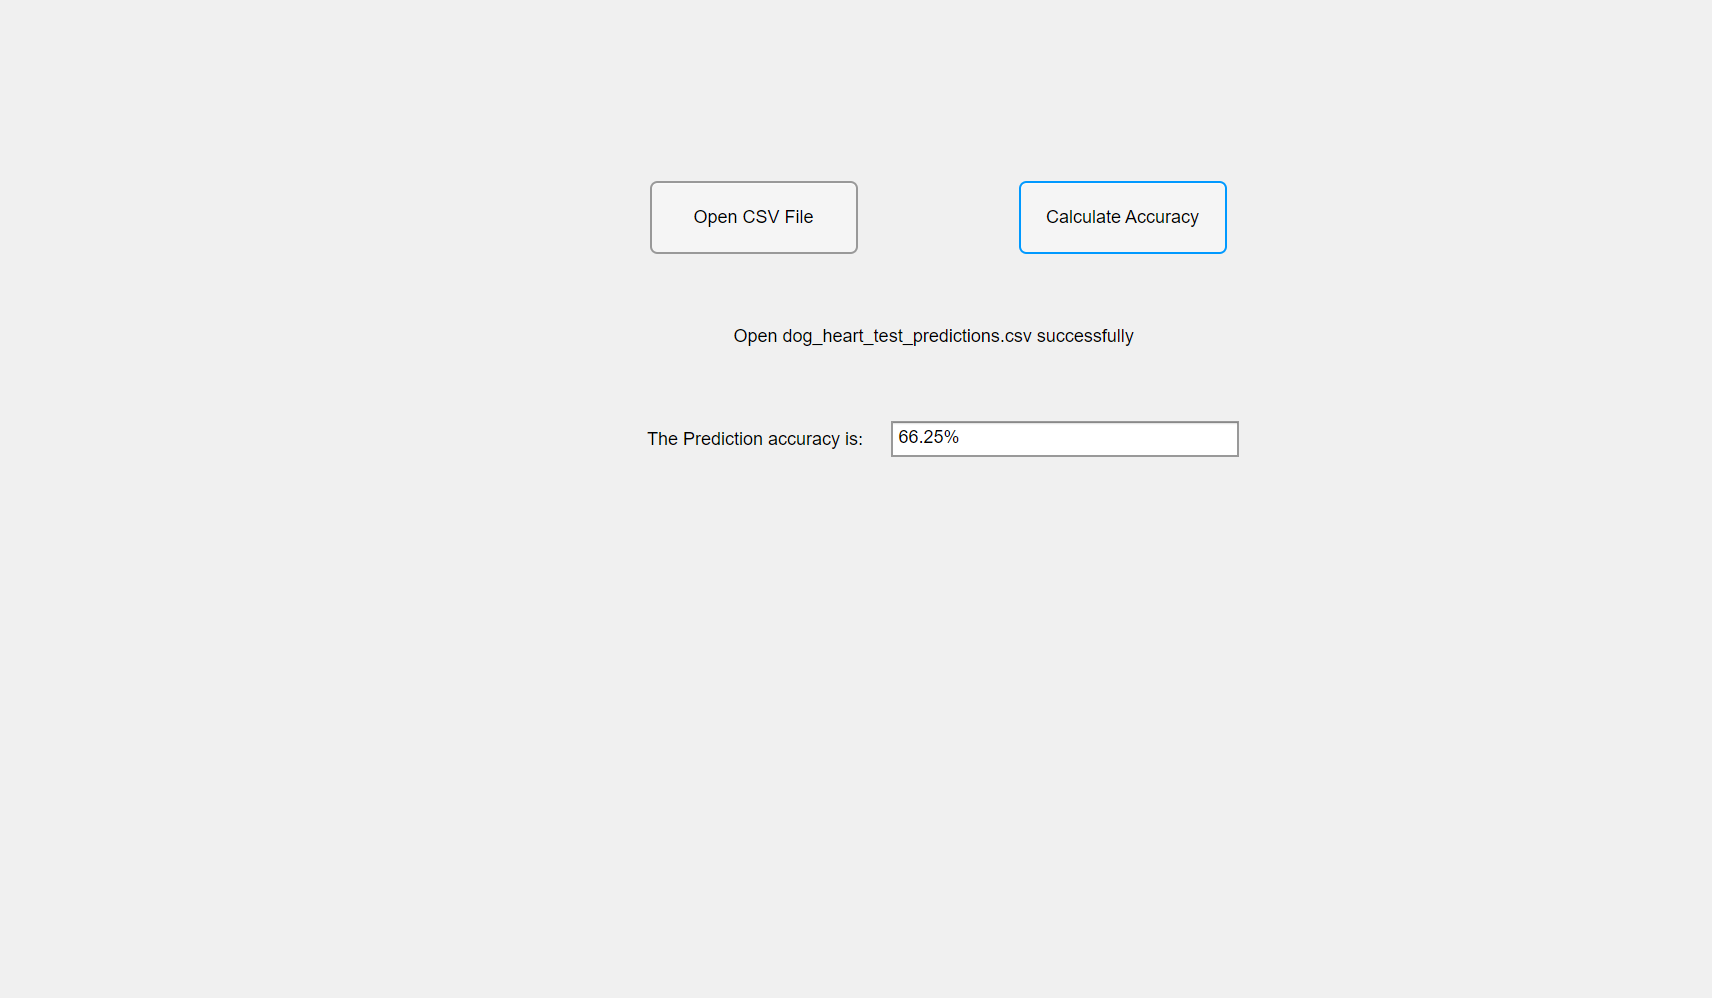

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 75%

According to the RVT paper, the VGG16 model achieved a test accuracy of 75% on their classification task involving canine radiographs.

In this project, the custom CNN model achieved:

* **Training Accuracy:** 95.71%

* **Test Accuracy:** 8 66.25%

Although the test accuracy did not surpass the VGG16 baseline, the model demonstrated strong training performance and consistent learning. The gap between training and test accuracy suggests potential overfitting, likely due to:

* Small dataset size

* Lack of input normalization

* Class imbalance

Despite these limitations, the custom CNN—being lightweight and built from scratch—offers a strong starting point. With improvements like data augmentation, batch normalization, and transfer learning, this model could potentially exceed VGG16 performance in future iterations.

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

In [ ]:
https://www.researchgate.net/publication/390177847_A_Lightweight_Convolutional_Neural_Network_for_Dog_Heart_Image_Classification